# Summary:

#### In this notebook, a continuous time series is generated and a neural network utilized to learn its shape and forecasts its future states.
#### More specifically, the time series is given in the form of a sine wave. Two recurrent neural networks from tensorflow's Keras are trained: a simple RNN and an LSTM neural net. Error and performance metrics are evaluated for both and results visualized.

#### Both models have the same number of units and are trained on the same number of epochs. Both use relu-activation functions and are optimized using an adam-optimizer.

#### The steps outlined in this notebook will be used in the notebook '02_Freddie_Freeloader.ipynb' to analyze the dependence of model-parameter choices on the model performance.


# Table of contents
* [1. Load modules](#Part1_link)
* [2. Setup data](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Generate time series: sine wave](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Separate training and validation data ](#Part2.2_link)

* [3. Feature scaling](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Standardize training data](#Part3.1_link)
* [4. Preprocess data](#Part4_link)
<br >&nbsp;&nbsp;&nbsp;[4.1 Cache, batch and shuffle using Tensorflow's data format](#Part4.1_link)
* [5. Setup and compile model](#Part5_link)
<br >&nbsp;&nbsp;&nbsp;[5.1 RNN](#Part5.1_link)
<br >&nbsp;&nbsp;&nbsp;[5.2 LSTM](#Part5.2_link)
* [6. Fit model](#Part6_link)
<br >&nbsp;&nbsp;&nbsp;[6.1 RNN](#Part6.1_link)
<br >&nbsp;&nbsp;&nbsp;[6.2 LSTM](#Part6.2_link)
* [7. Loss and error metrics](#Part7_link)
<br >&nbsp;&nbsp;&nbsp;[7.1 RNN](#Part7.1_link)
<br >&nbsp;&nbsp;&nbsp;[7.2 LSTM](#Part7.2_link)

<a id='Part1_link'></a>
# 1. Load modules

In [1]:
import sys
sys.path.append("../src/")
import Kind_of_Blue  # own class with a collection of methods used in this analysis

import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd


<a id='Part2_link'></a>
# 2. Setup data

<a id='Part2.1_link'></a>
### 2.1 Generate time series: sine wave

The dataset used in this initial experiment is a simple sine wave. The number of data points in each period is kept fixed thoughout the analysis.

In [2]:
# set a range of dates on which the observations are made
idx = pd.date_range(end='7/1/2020', periods=5*364, freq='d')

# take a sine function as the observations
num_periods = 10  # number of sine periods
observations = [np.sin(2*np.pi*num_periods*x/len(idx)) for x in range(len(idx))]
print('number of observations in time series: {}'.format(len(observations)))

# initialize dataframe to store time series
df = pd.DataFrame(data=observations, columns=['observations'])
df.index = idx

# initialize object
mdq = Kind_of_Blue.Kind_of_Blue()

# load dataframe into object
mdq._selected_features = ['observations']
mdq.df = df
mdq.df.head()

number of observations in time series: 1820


,observations
2015-07-09,0.000000
2015-07-10,0.034516
2015-07-11,0.068991
2015-07-12,0.103384
2015-07-13,0.137654


<a id='Part2.2_link'></a>
### 2.2 Separate training and validation data 

In [3]:
# train-validation split ratio as class attribute set to 70%
print('train split ratio = ', mdq.TRAIN_SPLIT_RATIO)

train split ratio =  0.7


In [4]:
# initialize dataset from dataframe 
mdq.initialize_dataset()

print('loaded data set length: {}'.format(len(mdq._dataset)))

loaded data set length: 1820


<a id='Part3_link'></a>
# 3. Feature scaling

<a id='Part3.1_link'></a>
### 3.1 Standardize training data

In [5]:
# standardize data
mdq.standardize_data()

# check that mean equals zero and the standard deviation is one
print('mean: {}, std: {}'.format(round(np.mean(mdq._dataset), 2), round(np.std(mdq._dataset), 2)))

mean: 0.0, std: 1.0


<a id='Part4_link'></a>
# 4. Preprocess data

<a id='Part4.1_link'></a>
### 4.1 Cache, batch and shuffle using Tensorflow's data format

The number time points to be forecasted and the number of points the model is trained on are set. The training and validation dataset is generated.

In [6]:
# set number of time points for 1/ future forecasting points and 2/ the past, historical time points
future_target_size = int(365/52)
past_history_size = int(1*365)

# generate training and validation data
mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size)

"""
data shapes: (batch size, number of input time steps, number of features)\
"""

print('number of training samples: {}'.format(mdq._num_samples))

training set shape: x:(909, 365, 1), y:(909, 7, 1)
validation set shape: x:(174, 365, 1), y:(174, 7, 1)
number of training samples: 909


<a id='Part5_link'></a>
# 5. Setup and compile model

In [7]:
# set model specifics for both neural networks
units = 96
num_layers = 2


<a id='Part5.1_link'></a>
### 5.1 RNN 

In [8]:
# setup Keras LSTM model and compile

model_type = 'RNN'
mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

# check that model exists in mdq-object
print('test that model got created in object instance: \n', mdq._models)

test that model got created in object instance: 
 {'RNN': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f80d6c01d50>}


<a id='Part5.2_link'></a>
### 5.2 LSTM 

Using Keras, the configuration details of the LSTM model is set and compiled.

In [9]:
# setup Keras LSTM model and compile

model_type = 'LSTM'
mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

# check that model exists in mdq-object
print('test that model got created in object instance: \n', mdq._models)

debugLSTM: should an LSTM layer or a Dense layer be added?
test that model got created in object instance: 
 {'RNN': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f80d6c01d50>, 'LSTM': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f80cfb86890>}


<a id='Part6_link'></a>
# 6. Fit model

<a id='Part6.1_link'></a>
### 6.1 RNN

Setting the number of epochs and steps per epoch, the model is fit to the training data. The generated 'history' will be used in the following section to assess the quality of the fit.

In [10]:
# set number of epochs
epochs = 30

# set number of steps per epoch
num_samples = mdq._num_samples
steps_per_epoch = int(num_samples/future_target_size)

validation_steps = int(steps_per_epoch/2)

model_type = 'RNN'
mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
              ,validation_steps=validation_steps, model_type=model_type)

Epoch 1/30
129/129 [==============================] - 16s 127ms/step - loss: 0.0941 - mse: 0.0941 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 2/30
129/129 [==============================] - 16s 124ms/step - loss: 0.2681 - mse: 0.2681 - val_loss: 0.0539 - val_mse: 0.0539
Epoch 3/30
129/129 [==============================] - 15s 120ms/step - loss: 0.1026 - mse: 0.1026 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 4/30
129/129 [==============================] - 18s 136ms/step - loss: 0.0785 - mse: 0.0785 - val_loss: 0.0493 - val_mse: 0.0493
Epoch 5/30
129/129 [==============================] - 18s 136ms/step - loss: 0.0809 - mse: 0.0809 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 6/30
129/129 [==============================] - 19s 147ms/step - loss: 0.0705 - mse: 0.0705 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 7/30
129/129 [==============================] - 15s 117ms/step - loss: 0.0637 - mse: 0.0637 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 8/30
129/129 [==============================] - 1

In [11]:
total_training_time = sum(mdq._time_callbacks[model_type].times)
print('total training time: {}'.format(total_training_time))

total training time: 533.7040257453918


<a id='Part6.2_link'></a>
### 6.2 LSTM

In [12]:
model_type = 'LSTM'
mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
              ,validation_steps=validation_steps, model_type=model_type)

Epoch 1/30
129/129 [==============================] - 83s 645ms/step - loss: 0.2546 - mse: 0.2546 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 2/30
129/129 [==============================] - 71s 548ms/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 3/30
129/129 [==============================] - 67s 518ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 4/30
129/129 [==============================] - 66s 512ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/30
129/129 [==============================] - 72s 556ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 6/30
129/129 [==============================] - 81s 629ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/30
129/129 [==============================] - 77s 598ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 8/30
129/129 [==============================] - 6

In [13]:
total_training_time = sum(mdq._time_callbacks[model_type].times)
print('total training time: {}'.format(total_training_time))

total training time: 1989.1168315410614


<a id='Part7_link'></a>
# 7. loss and error metrics

<a id='Part7.1_link'></a>
### 7.1 RNN

Visualize training and validation history

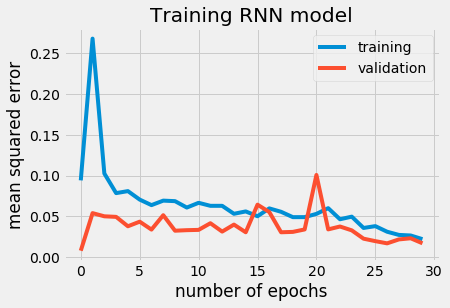

In [14]:
model_type = 'RNN'
mdq.plot_history(model_type=model_type)

Assess error metrics

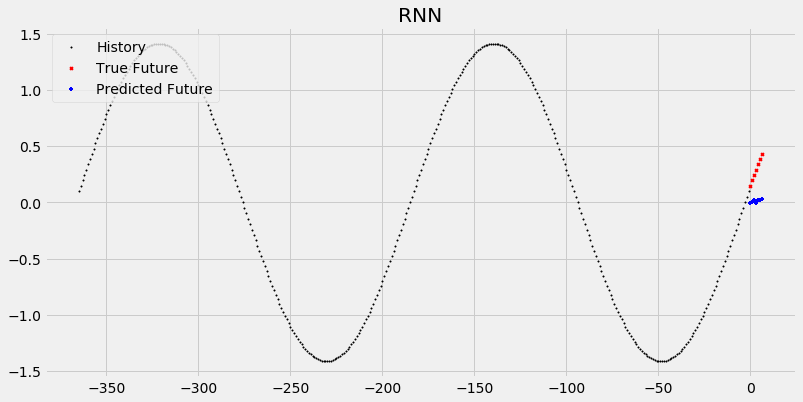

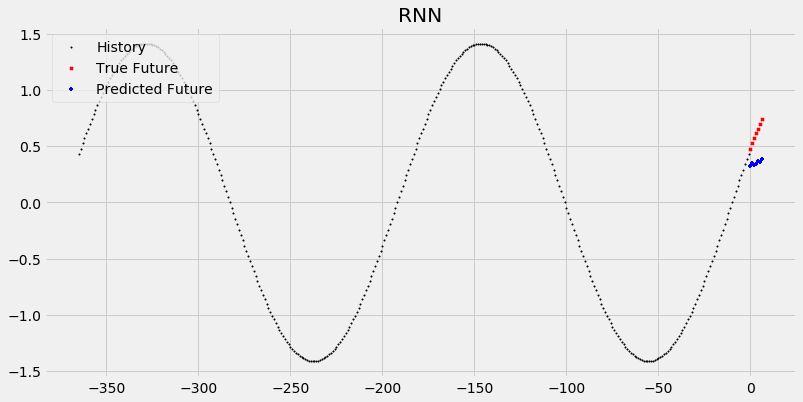

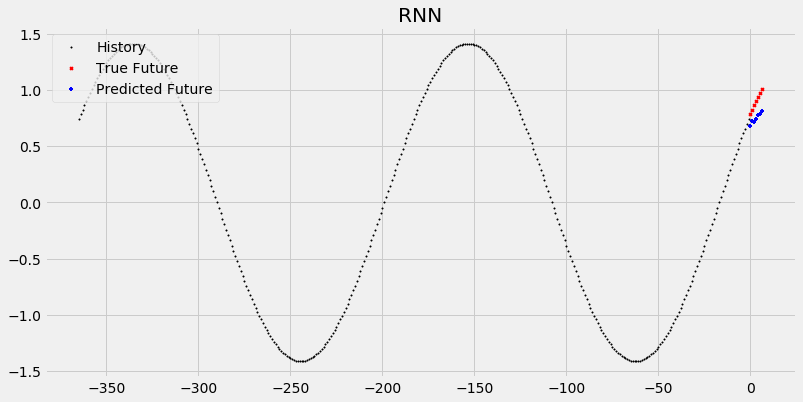

In [15]:
# visualize predictions

num = 2
for x, y in mdq._val_data.take(3):
    mdq.multi_step_plot(x[num], y[num], mdq._models[model_type].predict(x)[:1], xlabel=None, title=model_type)

<a id='Part7.2_link'></a>
### 7.2 LSTM

Visualize training and validation history

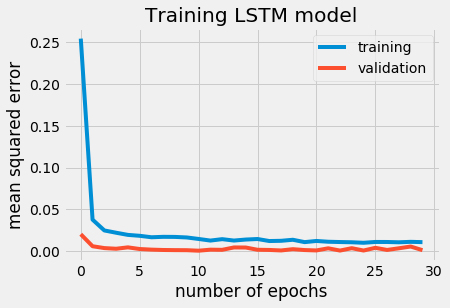

In [16]:
model_type = 'LSTM'
mdq.plot_history(model_type=model_type)

Assess error metrics

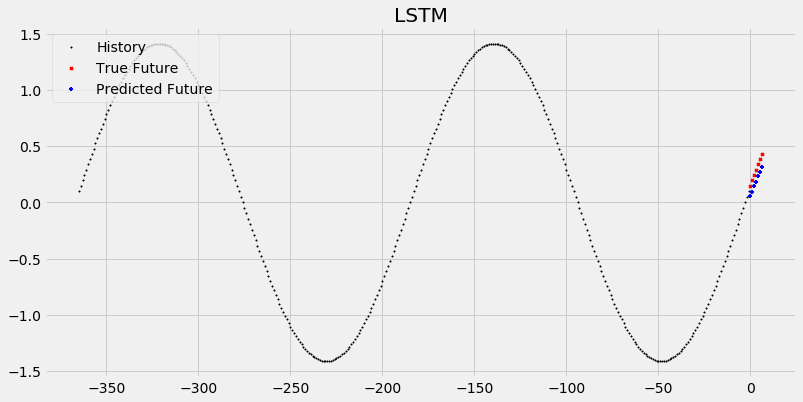

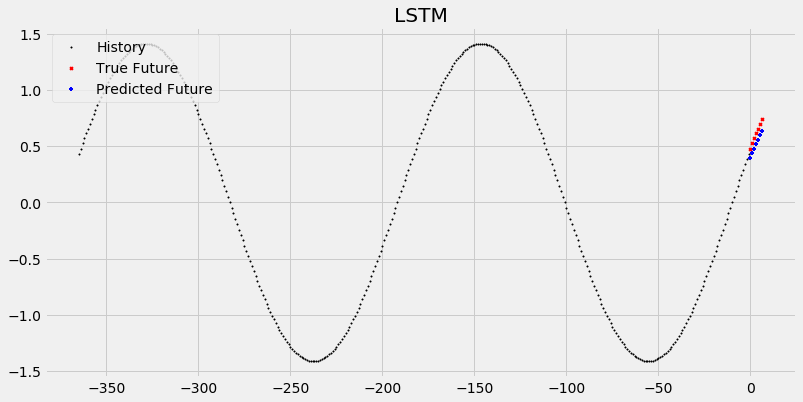

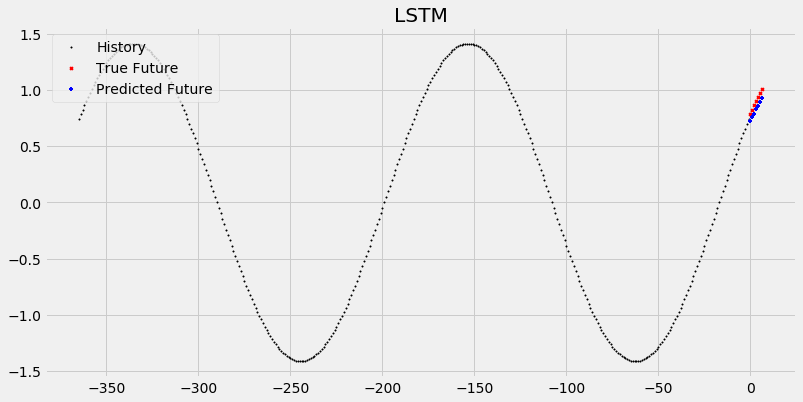

In [17]:
# visualize predictions

num = 2
for x, y in mdq._val_data.take(3):
    mdq.multi_step_plot(x[num], y[num], mdq._models[model_type].predict(x)[:1], xlabel=None, title=model_type)